In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory


In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


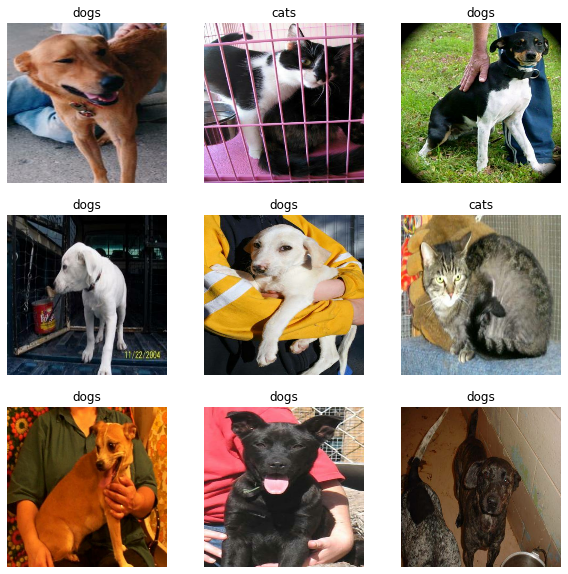

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=validation_dataset)

Epoch 1/15
63/63 [==============================] - 57s 910ms/step - loss: 0.6605 - accuracy: 0.6120 - val_loss: 0.4774 - val_accuracy: 0.7562
Epoch 2/15
63/63 [==============================] - 57s 907ms/step - loss: 0.5045 - accuracy: 0.7305 - val_loss: 0.3536 - val_accuracy: 0.8564
Epoch 3/15
63/63 [==============================] - 57s 905ms/step - loss: 0.4110 - accuracy: 0.7970 - val_loss: 0.2847 - val_accuracy: 0.8837
Epoch 4/15
63/63 [==============================] - 61s 971ms/step - loss: 0.3538 - accuracy: 0.8210 - val_loss: 0.2282 - val_accuracy: 0.9171
Epoch 5/15
63/63 [==============================] - 60s 948ms/step - loss: 0.3022 - accuracy: 0.8590 - val_loss: 0.2046 - val_accuracy: 0.9295
Epoch 6/15
63/63 [==============================] - 57s 903ms/step - loss: 0.2797 - accuracy: 0.8755 - val_loss: 0.1750 - val_accuracy: 0.9418
Epoch 7/15
63/63 [==============================] - 57s 901ms/step - loss: 0.2539 - accuracy: 0.8870 - val_loss: 0.1614 - val_accuracy: 0.9517

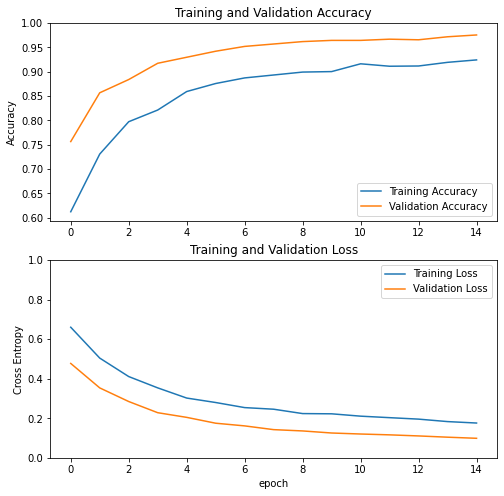

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 92s 1s/step - loss: 0.6986 - accuracy: 0.5105 - val_loss: 0.6346 - val_accuracy: 0.5730
Epoch 2/10
63/63 [==============================] - 90s 1s/step - loss: 0.5729 - accuracy: 0.6285 - val_loss: 0.5137 - val_accuracy: 0.7030
Epoch 3/10
63/63 [==============================] - 91s 1s/step - loss: 0.4836 - accuracy: 0.7210 - val_loss: 0.4284 - val_accuracy: 0.7983
Epoch 4/10
63/63 [==============================] - 90s 1s/step - loss: 0.4229 - accuracy: 0.7815 - val_loss: 0.3636 - val_accuracy: 0.8428
Epoch 5/10
63/63 [==============================] - 92s 1s/step - loss: 0.3730 - accuracy: 0.8240 - val_loss: 0.3167 - val_accuracy: 0.8899
Epoch 6/10
63/63 [==============================] - 93s 1s/step - loss: 0.3317 - accuracy: 0.8510 - val_loss: 0.2817 - val_accuracy: 0.9072
Epoch 7/10
63/63 [==============================] - 92s 1s/step - loss: 0.3050 - accuracy: 0.8700 - val_loss: 0.2571 - val_accuracy: 0.9109
Epoch 8/10
63/63 [==

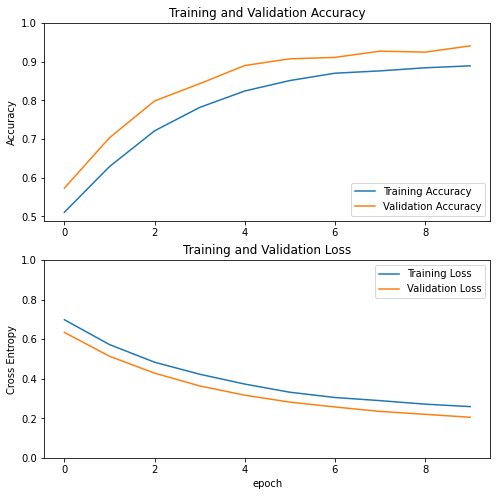

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  237


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 150s 2s/step - loss: 0.1944 - accuracy: 0.9210 - val_loss: 0.1044 - val_accuracy: 0.9641
Epoch 11/20
63/63 [==============================] - 150s 2s/step - loss: 0.1172 - accuracy: 0.9560 - val_loss: 0.0728 - val_accuracy: 0.9740
Epoch 12/20
63/63 [==============================] - 160s 3s/step - loss: 0.0950 - accuracy: 0.9645 - val_loss: 0.0581 - val_accuracy: 0.9777
Epoch 13/20
63/63 [==============================] - 155s 2s/step - loss: 0.0820 - accuracy: 0.9710 - val_loss: 0.0497 - val_accuracy: 0.9814
Epoch 14/20
63/63 [==============================] - 153s 2s/step - loss: 0.0649 - accuracy: 0.9760 - val_loss: 0.0543 - val_accuracy: 0.9777
Epoch 15/20
63/63 [==============================] - 149s 2s/step - loss: 0.0699 - accuracy: 0.9725 - val_loss: 0.0413 - val_accuracy: 0.9814
Epoch 16/20
63/63 [==============================] - 151s 2s/step - loss: 0.0574 - accuracy: 0.9765 - val_loss: 0.0474 - val_accuracy: 0.9814
Epoch 

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

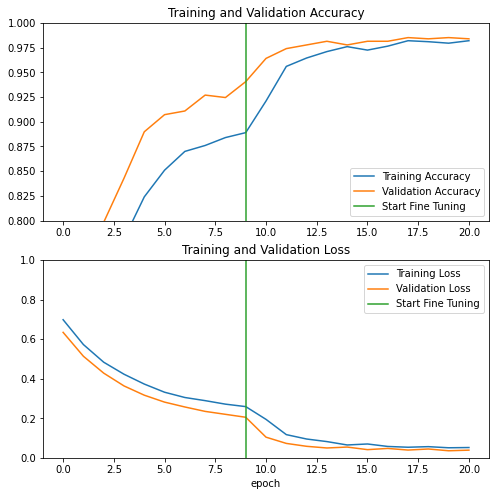

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 5s 803ms/step - loss: 0.0613 - accuracy: 0.9844
Test accuracy : 0.984375


In [ ]:
model.save('Effb0_catsvsdogs.h5')

# New section